The purpose of this notebook is to test whether adding addition features of the number of max consecutive y peaks and "perc_in_ladder"(need to say better) helps MokaPot to score more PSMs at or below a certain cuttoff. 

In [1]:
import os
import mokapot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
sys.path
import data_loader as dl

The purpose of this function is to clean up the original 'before' data so that we are not counting decoys or duplicate scans.

In [2]:
def filter_data(df, prob_column):
     #drop decoys
    df = df[df["decoy"]== False]
    #sort by qvalue
    df = df.sort_values(prob_column)
    #Drop duplicates
    df = df.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring

    return df

This gives us the before data. It will not be run through MokaPot. It's purpose is to give us the ability to count how many PSMs originally are at or under a specific cutoff and compare that to the number we get after we run the data through MokaPot. 

In [3]:
def get_PreMokaPot_data(file):
    data = dl.clean_metamorph(file)
    data = filter_data(data,'QValue')
    return data

This reads in and cleans the data that will be run through MokaPot. MetaMorphues has a special output file that is formatted to be able to run through MokaPot.

In [4]:
def get_data_for_MokaPot(file):
    df_2 = dl.get_pin_file(file)
    df_2 = df_2.iloc[1: :]
    df_2 = df_2.drop_duplicates(subset=["ScanNr"], keep="first")
    
    return df_2

This function gives us back the absolute value of the difference between the predicted retention time from AutoRT and the actual retention time given back from MetaMorpheus. *Must be the absolute value.

In [5]:
def calculate_diff(row):
    num = row['y'] - row['y_pred']
    if num < 0:
        num = num * (-1)
    return num

MetaMorpheus gives an output file that is specifically formatted for MokaPot. However, this file does not have q values, which we need to compare the before and after data. However, once the decoys are dropped from both files, the regular before file and the specailly formatted file contain the same scan numbers.
The before file is used to compute the number of max consecutive y peaks and "perc_in_ladder". These columns are then taken and then added to the specially formatted file. 

Here we read in the speically formatted file and the file that has the additional feature columns in it. Decoys are dropped from both of them, giving us the same number of scans in both file. We splice out the scan, max_consecutive_y, and "perc_in_ladder" columns. These columns are then joined with the formatted file based on their scan numbers. We can use this file to run through MokaPot and compare if the extra feature columns help MokaPot to score more PSMs below our cutoff. 

In [6]:
def get_peaks_data(pin_df, before_df):

    data = pd.read_csv(before_df)
    
    #Change the ladder column tye to float and changing NAN value to 0 (this will be fixed later)
    data['perc_in_ladder'].replace('NAN', "0", inplace = True)
    data = data.astype({"perc_in_ladder": float})
    
    #sort based on the probability column
    data = data.sort_values('probability')
    #drop duplicate scans
    data = data.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring
    
    data = data.rename(columns = {"scan": "ScanNr"})
    data = data.filter(['ScanNr', 'max_consecutive_y', "perc_in_ladder"])
    data = data.set_index("ScanNr")
    
    #setting up the data from the pin file
    df_2 = dl.get_pin_file(pin_df)
    df_2 = df_2.iloc[1: :]
    df_2 = df_2.astype({"ScanNr": int})
    df_2 = df_2.drop_duplicates(subset=["ScanNr"], keep="first")
    df_2 = df_2.set_index("ScanNr")
    
    
    joined_df = df_2.join(data, how = "outer")
    joined_df.reset_index(inplace=True)
    
    return joined_df
    

Here we read in the speically formatted file and the file that has the additional feature columns in it. Decoys are dropped from both of them, giving us the same number of scans in both file. We splice out the scan, and difference columns. These columns are then joined with the formatted file based on their scan numbers. We can use this file to run through MokaPot and compare if the extra feature columns help MokaPot to score more PSMs below our cutoff.

In [7]:
#Retriving and formatting the df that has the retention time info in it. Also doing the math to get 
#the difference colum

def retrive_RT_df(before_df):
    
    data = pd.read_csv(before_df, sep = "\t")    
    
    #sort based on the probability column
    data = data.sort_values('QValue')
    #drop duplicate scans
    data = data.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring
    #changing the type
    data = data.astype({'y_pred': float})
    
    #calculating the difference column
    data['difference'] = data.apply(calculate_diff, axis = 1)
    
    data = data.rename(columns = {"scan": "ScanNr"})
    data = data.filter(['ScanNr', 'difference'])
    data = data.set_index("ScanNr")
    return data


In [8]:
def get_retentionTime_data(pin_df, before_df):

    data = retrive_RT_df(before_df)
    
    #setting up the data from the pin file
    df_2 = dl.get_pin_file(pin_df)
    df_2 = df_2.iloc[1: :]
    df_2 = df_2.astype({"ScanNr": int})
    df_2 = df_2.drop_duplicates(subset=["ScanNr"], keep="first")
    df_2 = df_2.set_index("ScanNr")
    
    
    joined_df = df_2.join(data, how = "outer")
    joined_df.reset_index(inplace=True)
    
    return joined_df

Taking the dataframe that has the peaks features added on and joining the additional retention time differnce column onto it. Returning the joined dataframe

In [9]:
def get_all_features_data(peaksData, RTdata):
    RTdata = RTdata.filter(['ScanNr', 'difference'])
    RTdata = RTdata.set_index("ScanNr")
    RTdata = RTdata.astype({'difference': float})
    
    peaksData = peaksData.set_index("ScanNr")
    peaksData = peaksData.astype({'perc_in_ladder': float})
    
    joined_df = peaksData.join(RTdata, how = "outer")
    joined_df.reset_index(inplace=True)
    
    return joined_df
   
    

This is code that was taken directly from the MokaPot program. It formats the data for the graphs. The purpose of the graphs is to compare the preMokaPot data to the postMokaPot data and compare if we are getting more scans at or below a certain cutoff after running data through MokaPot.

In [10]:
def plot_qvalues(qvalues, threshold=0.01, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # Calculate cumulative targets at each q-value
    qvals = pd.Series(qvalues, name="qvalue")
    qvals = qvals.sort_values(ascending=True).to_frame()
    qvals["target"] = 1
    qvals["num"] = qvals["target"].cumsum()
    qvals = qvals.groupby(["qvalue"]).max().reset_index()
    qvals = qvals[["qvalue", "num"]]

    zero = pd.DataFrame({"qvalue": qvals["qvalue"][0], "num": 0}, index=[-1])
    qvals = pd.concat([zero, qvals], sort=True).reset_index(drop=True)

    xmargin = threshold * 0.05
    ymax = qvals.num[qvals["qvalue"] <= (threshold + xmargin)].max()
    ymargin = ymax * 0.05

    # Set margins
    curr_ylims = ax.get_ylim()
    if curr_ylims[1] < ymax + ymargin:
        ax.set_ylim(0 - ymargin, ymax + ymargin)

    ax.set_xlim(0 - xmargin, threshold + xmargin)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Discoveries")

    ax.step(qvals["qvalue"].values, qvals.num.values, where="post", **kwargs)

    return ax

In [11]:
def plot_qvalues(qvalues, threshold=0.01, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # Calculate cumulative targets at each q-value
    qvals = pd.Series(qvalues, name="qvalue")
    qvals = qvals.sort_values(ascending=True).to_frame()
    qvals["target"] = 1
    qvals["num"] = qvals["target"].cumsum()
    qvals = qvals.groupby(["qvalue"]).max().reset_index()
    qvals = qvals[["qvalue", "num"]]

    zero = pd.DataFrame({"qvalue": qvals["qvalue"][0], "num": 0}, index=[-1])
    qvals = pd.concat([zero, qvals], sort=True).reset_index(drop=True)

    xmargin = threshold * 0.05
    ymax = qvals.num[qvals["qvalue"] <= (threshold + xmargin)].max()
    ymargin = ymax * 0.05

    # Set margins
    curr_ylims = ax.get_ylim()
    if curr_ylims[1] < ymax + ymargin:
        ax.set_ylim(0 - ymargin, ymax + ymargin)

    ax.set_xlim(0 - xmargin, threshold + xmargin)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Discoveries")

    ax.step(qvals["qvalue"].values, qvals.num.values, where="post", **kwargs)

    return ax

In [12]:
#Read all the files into a list here
file_names = ["2ng_rep1"]

In order to tell if the new added features are helping MokaPot to score the PSMs higher, we run the program a certain number of times and look at the average scores.
We read in the data for the pin file, the regular data, and the data that has the added features. Because MokaPot gives an output file that is already formatted for MokaPot, we have to splice out the extra columns and joing them with the pin file.

In [13]:
rounds = 0
limit = 25

no_addedFeats_list = []
peaks_feature_list = []
RT_feature_list = []
all_features_list = []

original_MM = get_PreMokaPot_data('2ng_rep1')
regular_df = get_data_for_MokaPot('2ng_rep1')
peaks_df = get_peaks_data("2ng_rep1", "2ng_rep1_new_features.csv")
RT_df = get_retentionTime_data("2ng_rep1", "test.tsv")
all_feats_df = get_all_features_data(peaks_df, RT_df)


while rounds < limit:

    mm_for_MP = mokapot.read_pin(regular_df) 
    regular_results, models = mokapot.brew(mm_for_MP)


    mm_peaksFeat_MP = mokapot.read_pin(peaks_df) 
    peaksAdded_results, added_models = mokapot.brew(mm_peaksFeat_MP)
    
    mm_RT_feat_MP = mokapot.read_pin(RT_df)
    RTadded_results, models = mokapot.brew(mm_RT_feat_MP)
    
    all_features_MP = mokapot.read_pin(all_feats_df)
    allAdded_results, models = mokapot.brew(all_features_MP)

      
    no_addedFeats_list.append(len(regular_results.psms[regular_results.psms['mokapot q-value'] <= 0.01]))
    print("without added feat: " + str(len(regular_results.psms[regular_results.psms['mokapot q-value'] <= 0.01])))
    
    peaks_feature_list.append(len(peaksAdded_results.psms[peaksAdded_results.psms['mokapot q-value'] <= 0.01]))
    print("with peaks feat: " + str(len(peaksAdded_results.psms[peaksAdded_results.psms['mokapot q-value'] <= 0.01])))
    
    RT_feature_list.append(len(RTadded_results.psms[RTadded_results.psms['mokapot q-value'] <= 0.01]))
    print("with RT feat: " + str(len(RTadded_results.psms[RTadded_results.psms['mokapot q-value'] <= 0.01])))
    
    all_features_list.append(len(allAdded_results.psms[allAdded_results.psms['mokapot q-value'] <= 0.01]))
    print("with all added feat: " + str(len(allAdded_results.psms[allAdded_results.psms['mokapot q-value'] <= 0.01])))
    
    rounds+= 1
    print("finished round " + str(rounds))
  

    

/Users/daishavanderwatt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/daishavanderwatt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (12,22,23,24,75) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/daishavanderwatt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


without added feat: 14355
with peaks feat: 14654
with RT feat: 14792
with all added feat: 14812
finished round 1
without added feat: 14402
with peaks feat: 14700
with RT feat: 14772
with all added feat: 14826
finished round 2
without added feat: 14445
with peaks feat: 14742
with RT feat: 14514
with all added feat: 14824
finished round 3
without added feat: 14360
with peaks feat: 14726
with RT feat: 14786
with all added feat: 14532
finished round 4
without added feat: 14655
with peaks feat: 14754
with RT feat: 14791
with all added feat: 14844
finished round 5
without added feat: 14561
with peaks feat: 14709
with RT feat: 14803
with all added feat: 14836
finished round 6
without added feat: 14579
with peaks feat: 14691
with RT feat: 14787
with all added feat: 14854
finished round 7
without added feat: 14354
with peaks feat: 14728
with RT feat: 14815
with all added feat: 14830
finished round 8
without added feat: 14385
with peaks feat: 14443
with RT feat: 14479
with all added feat: 14813


In [14]:
def get_avg(num_list):
    total = 0
    for num in num_list:
        total = total + num
    avg = total/len(num_list)
    return avg

   
print("Average scores after 25 runs:")  

print("\t" + "MetaMorpheus native data: " + str(len((original_MM[original_MM['QValue'] <= 0.01]))))

print("\t" + "MetaMorpheus and MokaPot without additional features: ")
print("\t\t" + "Average: " + str(np.mean(no_addedFeats_list)))
print("\t\t" + "Error: " + str(np.std(no_addedFeats_list)))

print("\t" + "MetaMorpheus and MokaPot with additional peak features: ")
print("\t\t" + "Average: " + str(np.mean(peaks_feature_list)))
print("\t\t" + "Error: " + str(np.std(peaks_feature_list)))

print("\t" + "MetaMorpheus and MokaPot with additional RT difference features: " )
print("\t\t" + "Average: " + str(np.mean(RT_feature_list)))
print("\t\t" + "Error: " + str(np.std(RT_feature_list)))

print("\t" + "MetaMorpheus and MokaPot with all additional features: ")
print("\t\t" + "Average: " + str(np.mean(all_features_list)))
print("\t\t" + "Error: " + str(np.std(all_features_list)))
        

Average scores after 25 runs:
	MetaMorpheus native data: 12446
	MetaMorpheus and MokaPot without additional features: 
		Average: 14413.56
		Error: 140.95902383316934
	MetaMorpheus and MokaPot with additional peak features: 
		Average: 14621.4
		Error: 126.3727818796437
	MetaMorpheus and MokaPot with additional RT difference features: 
		Average: 14704.64
		Error: 169.88605122257684
	MetaMorpheus and MokaPot with all additional features: 
		Average: 14750.2
		Error: 135.49022104934363


Making the graph for the average number of PSMs at or under a 0.01 cutoff. Standard deviation is given as well.

In [15]:
df = pd.DataFrame(list(zip(no_addedFeats_list, all_features_list)),
               columns =['No Features', 'All Features'])
df

,No Features,All Features
0,14355,14812
1,14402,14826
2,14445,14824
3,14360,14532
4,14655,14844
5,14561,14836
6,14579,14854
7,14354,14830
8,14385,14813
9,14345,14812


In [16]:
from scipy import stats
t_test = stats.ttest_ind(df["No Features"], df["All Features"])
pval = t_test.pvalue

formatted_string = "{:.12f}".format(pval)
pvalue = float(formatted_string)

print(pvalue)

4.9e-11


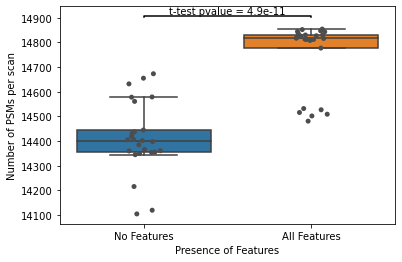

In [22]:
import seaborn as sns

features_plot = sns.boxplot(data=df, showfliers=False)
features_plot = sns.stripplot(data=df, jitter=True, color=".3")
features_plot.set(ylabel = "Number of PSMs per scan")
features_plot.set(xlabel = "Presence of Features")


#statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = df['All Features'].max() + 50, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "t-test pvalue = " + str(pvalue), ha='center', va='bottom', color=col)

figure3 = plt.gcf()
figure3.savefig('features_graph', dpi=300, bbox_inches='tight')


plt.show()


#put the pvalue in the legend